# TROPOMI S5P NO2 Level 2 - Single File Processing and Visualization

## About

This notebook demonstrates loading data from a single TROPOMI S5P Level 2 NO2 (NetCDF4/HDF5) file. It performs the following:
1. Extracts latitude, longitude, UTC time, QA value, and tropospheric NO2 column from the `/PRODUCT` group.
2. Filters the data for `qa_value > 0.5`.
3. Visualizes maps of the filtered tropospheric NO2 column in both `mol m-2` and `molecules cm-2`.
4. Saves the extracted and filtered pixel data to an ASCII (CSV) file, including NO2 in both units.

## Step 1: Load Python Libraries

In [1]:
import xarray as xr 
import numpy as np      
import os                    
import datetime              

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker 
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

## Step 2: User Settings and File Path

In [2]:
# --- User Settings --- #
# *** DEFINE THE FULL PATH TO YOUR SINGLE TROPOMI NO2 FILE HERE ***
tropomi_file_path = '../data/tropomi_no2/S5P_OFFL_L2__NO2____20240321T061037_20240321T075208_33353_03_020600_20240323T160427.nc' # Example path

output_image_dir = '../output/images/' 
output_ascii_dir = '../output/ascii/'   

# Variable paths within the NetCDF file (typically under /PRODUCT group for TROPOMI L2)
lat_var_path = '/PRODUCT/latitude'
lon_var_path = '/PRODUCT/longitude'
no2_var_path = '/PRODUCT/nitrogendioxide_tropospheric_column'
qa_var_path = '/PRODUCT/qa_value'
time_utc_var_path = '/PRODUCT/time_utc' # This is a 2D array of strings
# --- End User Settings --- #

os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_ascii_dir, exist_ok=True)

data_loaded_successfully = False
base_filename_for_output = "TROPOMI_NO2_Single_NoData"
if not os.path.exists(tropomi_file_path):
    print(f"Error: File not found at {tropomi_file_path}")
else:
    print(f"Processing file: {tropomi_file_path}")
    data_loaded_successfully = True 
    base_filename_for_output = os.path.splitext(os.path.basename(tropomi_file_path))[0]

Processing file: ../data/tropomi_no2/S5P_OFFL_L2__NO2____20240321T061037_20240321T075208_33353_03_020600_20240323T160427.nc


## Step 3: Load Data using `xarray`, Process, and Prepare for Plotting/Saving

In [3]:
latitude_granule_for_plot = None 
longitude_granule_for_plot = None 
no2_qa_filtered_granule_molm2 = None 
no2_qa_filtered_granule_molcm2 = None # For molecules/cm2 plot

ascii_pixels_datetime = []
ascii_pixels_lat = []
ascii_pixels_lon = []
ascii_pixels_no2_molm2 = []
ascii_pixels_no2_molcm2 = [] # For molecules/cm2 ASCII
ascii_pixels_qa = []

var_attributes = {}
map_extent_calculated = False
global_lat_min, global_lat_max, global_lon_min, global_lon_max = None, None, None, None
conversion_factor_to_mol_cm2 = 6.02214e19 # From metadata

if data_loaded_successfully: 
    ds = None
    try:
        ds = xr.open_dataset(tropomi_file_path, engine='h5netcdf', group='PRODUCT')
        print(f"  Successfully opened file and accessed /PRODUCT group: {os.path.basename(tropomi_file_path)}")
        
        latitude_granule_raw = ds['latitude'].data[0,:,:]
        longitude_granule_raw = ds['longitude'].data[0,:,:]
        no2_raw_granule = ds['nitrogendioxide_tropospheric_column'].data[0,:,:]
        qa_raw_granule = ds['qa_value'].data[0,:,:]
        time_utc_raw = ds['time_utc'].data[0,:]

        var_attributes['NO2_long_name'] = ds['nitrogendioxide_tropospheric_column'].attrs.get('long_name', 'Tropospheric NO2 Column')
        var_attributes['NO2_units'] = ds['nitrogendioxide_tropospheric_column'].attrs.get('units', 'mol m-2')
        var_attributes['NO2_fill_value'] = ds['nitrogendioxide_tropospheric_column'].attrs.get('_FillValue', np.nan)
        var_attributes['QA_fill_value'] = ds['qa_value'].attrs.get('_FillValue', 255)
        var_attributes['QA_scale_factor'] = ds['qa_value'].attrs.get('scale_factor', 1.0)
        var_attributes['QA_add_offset'] = ds['qa_value'].attrs.get('add_offset', 0.0)
        var_attributes['Lat_fill_value'] = ds['latitude'].attrs.get('_FillValue', np.nan)
        var_attributes['Lon_fill_value'] = ds['longitude'].attrs.get('_FillValue', np.nan)

        qa_fill_val = var_attributes['QA_fill_value']
        qa_processed_granule = np.where(qa_raw_granule == qa_fill_val, np.nan, qa_raw_granule.astype(float) * var_attributes['QA_scale_factor'] + var_attributes['QA_add_offset'])

        no2_fill_val = var_attributes['NO2_fill_value']
        no2_processed_granule_molm2 = np.where(no2_raw_granule == no2_fill_val, np.nan, no2_raw_granule)
        
        no2_qa_filtered_granule_molm2 = np.where(qa_processed_granule > 0.5, no2_processed_granule_molm2, np.nan)
        # Convert to molecules/cm^2 for the second plot and ASCII
        no2_qa_filtered_granule_molcm2 = no2_qa_filtered_granule_molm2 * conversion_factor_to_mol_cm2

        latitude_granule_for_plot = np.where(latitude_granule_raw == var_attributes['Lat_fill_value'], np.nan, latitude_granule_raw)
        longitude_granule_for_plot = np.where(longitude_granule_raw == var_attributes['Lon_fill_value'], np.nan, longitude_granule_raw)

        valid_lons = longitude_granule_for_plot[~np.isnan(longitude_granule_for_plot)]
        valid_lats = latitude_granule_for_plot[~np.isnan(latitude_granule_for_plot)]
        if valid_lons.size > 0 and valid_lats.size > 0:
            global_lon_min, global_lon_max = np.nanmin(valid_lons), np.nanmax(valid_lons)
            global_lat_min, global_lat_max = np.nanmin(valid_lats), np.nanmax(valid_lats)
            map_extent_calculated = True
            print("Map extent calculated:")
            print(f"  Longitude: {global_lon_min:.2f} to {global_lon_max:.2f}")
            print(f"  Latitude:  {global_lat_min:.2f} to {global_lat_max:.2f}")
        else:
            print("Warning: No valid longitude/latitude data for extent.")
            data_loaded_successfully = False 

        time_utc_pixel_granule = np.empty_like(latitude_granule_raw, dtype=object)
        for i in range(latitude_granule_raw.shape[0]):
            time_utc_pixel_granule[i, :] = time_utc_raw[i]

        for y_idx in range(latitude_granule_for_plot.shape[0]):
            for x_idx in range(latitude_granule_for_plot.shape[1]):
                current_no2_molm2_val = no2_qa_filtered_granule_molm2[y_idx, x_idx]
                current_no2_molcm2_val = no2_qa_filtered_granule_molcm2[y_idx, x_idx]
                current_qa_val = qa_processed_granule[y_idx, x_idx]
                current_lat_val = latitude_granule_for_plot[y_idx, x_idx]
                current_lon_val = longitude_granule_for_plot[y_idx, x_idx]
                current_time_str = time_utc_pixel_granule[y_idx, x_idx]
                
                if not np.isnan(current_no2_molm2_val) and not np.isnan(current_lat_val) and not np.isnan(current_lon_val):
                    try:
                        dt_obj = datetime.datetime.strptime(current_time_str.decode('utf-8') if isinstance(current_time_str, bytes) else current_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')
                        dt_obj = dt_obj.replace(tzinfo=datetime.timezone.utc)
                    except ValueError:
                        dt_obj = None 
                    
                    if dt_obj is not None:
                        ascii_pixels_datetime.append(dt_obj)
                        ascii_pixels_lat.append(current_lat_val)
                        ascii_pixels_lon.append(current_lon_val)
                        ascii_pixels_no2_molm2.append(current_no2_molm2_val)
                        ascii_pixels_no2_molcm2.append(current_no2_molcm2_val)
                        ascii_pixels_qa.append(current_qa_val if not np.isnan(current_qa_val) else -1.0)
        
        print(f"\nSuccessfully processed data from {tropomi_file_path}")

    except Exception as e:
        print(f"Error processing file {tropomi_file_path}: {e}")
        data_loaded_successfully = False
    finally:
        if ds:
            ds.close()
            print(f"  NetCDF file {os.path.basename(tropomi_file_path)} has been closed.")
else:
    print("File path was not valid initially or file not found. Nothing to process.")

print("Data loading and processing complete.")

  Successfully opened file and accessed /PRODUCT group: S5P_OFFL_L2__NO2____20240321T061037_20240321T075208_33353_03_020600_20240323T160427.nc
Map extent calculated:
  Longitude: -180.00 to 180.00
  Latitude:  -89.98 to 89.98

Successfully processed data from ../data/tropomi_no2/S5P_OFFL_L2__NO2____20240321T061037_20240321T075208_33353_03_020600_20240323T160427.nc
  NetCDF file S5P_OFFL_L2__NO2____20240321T061037_20240321T075208_33353_03_020600_20240323T160427.nc has been closed.
Data loading and processing complete.


## Step 4: Visualize and Save Tropospheric NO2 Maps
Tropospheric NO2 Column is filtered where `qa_value > 0.5`.

Tropospheric NO2 Map (mol m-2) saved to: ../output/images/S5P_OFFL_L2__NO2____20240321T061037_20240321T075208_33353_03_020600_20240323T160427_TropNO2_QA05_molm2.png


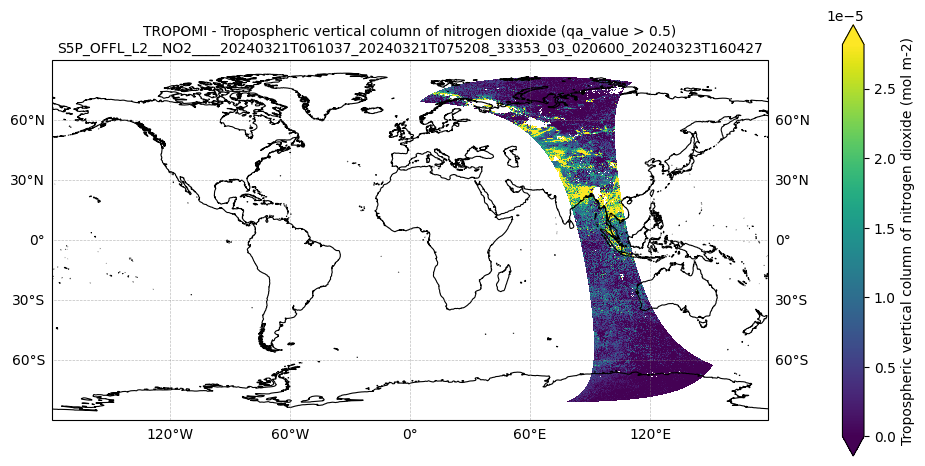

Tropospheric NO2 Map (molecules cm-2) saved to: ../output/images/S5P_OFFL_L2__NO2____20240321T061037_20240321T075208_33353_03_020600_20240323T160427_TropNO2_QA05_molcm2.png


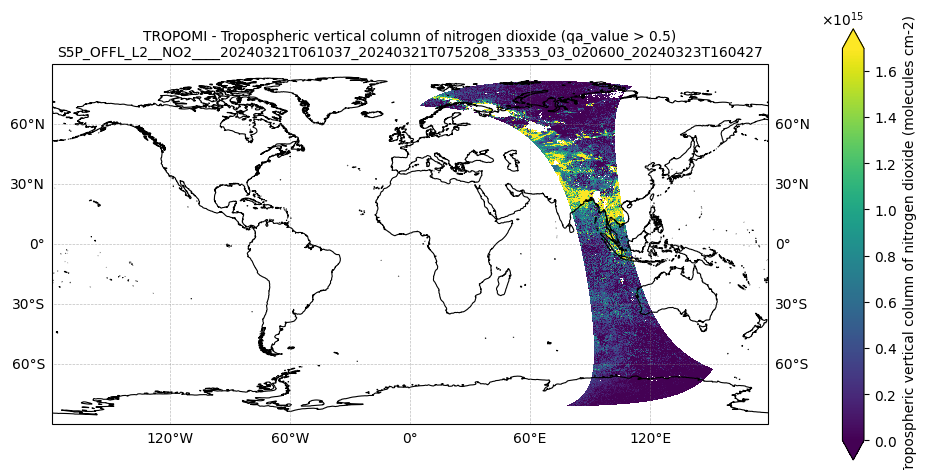

In [4]:
if data_loaded_successfully and map_extent_calculated and latitude_granule_for_plot is not None and no2_qa_filtered_granule_molm2 is not None:
    extent_padding_val = 1.0 
    map_extent_plot = [global_lon_min - extent_padding_val, global_lon_max + extent_padding_val, 
                       global_lat_min - extent_padding_val, global_lat_max + extent_padding_val]

    # --- Plot 1: NO2 in mol m-2 ---
    fig1 = plt.figure(figsize=(12, 8)) 
    ax1 = plt.axes(projection=ccrs.PlateCarree())
    try:
        ax1.set_extent(map_extent_plot, crs=ccrs.PlateCarree())
    except Exception as e:
        print(f"Error setting map extent {map_extent_plot} for mol m-2 plot: {e}. Using global extent.")
        ax1.set_global()
    
    ax1.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl1.top_labels = False; gl1.right_labels = True 
    gl1.xformatter = LONGITUDE_FORMATTER; gl1.yformatter = LATITUDE_FORMATTER
    
    plotted_mesh_no2_molm2 = None 
    no2_to_plot_molm2 = no2_qa_filtered_granule_molm2 

    valid_no2_data_molm2 = no2_to_plot_molm2[~np.isnan(no2_to_plot_molm2)]
    if valid_no2_data_molm2.size > 0:
        vmin_plot_molm2 = np.percentile(valid_no2_data_molm2, 5) 
        vmax_plot_molm2 = np.percentile(valid_no2_data_molm2, 95) 
        if vmin_plot_molm2 < 0: vmin_plot_molm2 = 0 
        if vmax_plot_molm2 <= vmin_plot_molm2: vmax_plot_molm2 = vmin_plot_molm2 + 1e-5 
    else:
        vmin_plot_molm2 = 0; vmax_plot_molm2 = 1e-4 

    if no2_to_plot_molm2.size > 0 and np.any(~np.isnan(no2_to_plot_molm2)):
        mesh1 = ax1.pcolormesh(longitude_granule_for_plot, latitude_granule_for_plot, no2_to_plot_molm2, 
                             transform=ccrs.PlateCarree(), cmap='viridis', 
                             vmin=vmin_plot_molm2, vmax=vmax_plot_molm2, shading='auto')
        plotted_mesh_no2_molm2 = mesh1
    
    no2_display_long_name = var_attributes.get('NO2_long_name', 'Tropospheric NO2 Column')
    no2_display_units_molm2 = var_attributes.get('NO2_units', 'mol m-2')
    title_str_prefix_molm2 = f'TROPOMI - {no2_display_long_name} (qa_value > 0.5)'
    title_str_suffix = base_filename_for_output

    if plotted_mesh_no2_molm2 is not None:
        cbar1 = plt.colorbar(plotted_mesh_no2_molm2, ax=ax1, orientation='vertical', pad=0.08, shrink=0.7, extend='both')
        cbar1.set_label(f"{no2_display_long_name} ({no2_display_units_molm2})")
        plt.title(f'{title_str_prefix_molm2}\n{title_str_suffix}', fontsize=10)
    else:
        print("No valid NO2 data (mol m-2) to plot for this file after QA filtering.")
        plt.title(f'{title_str_prefix_molm2}\nNo valid data in {title_str_suffix}', fontsize=10)
    
    save_filename_no2_molm2 = f"{base_filename_for_output}_TropNO2_QA05_molm2.png"
    plt.savefig(os.path.join(output_image_dir, save_filename_no2_molm2), dpi=300, bbox_inches='tight') 
    print(f"Tropospheric NO2 Map (mol m-2) saved to: {os.path.join(output_image_dir, save_filename_no2_molm2)}")
    plt.show() 
    plt.close(fig1)

    # --- Plot 2: NO2 in molecules cm-2 ---
    fig2 = plt.figure(figsize=(12, 8)) 
    ax2 = plt.axes(projection=ccrs.PlateCarree())
    try:
        ax2.set_extent(map_extent_plot, crs=ccrs.PlateCarree())
    except Exception as e:
        print(f"Error setting map extent {map_extent_plot} for molecules cm-2 plot: {e}. Using global extent.")
        ax2.set_global()
    
    ax2.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl2.top_labels = False; gl2.right_labels = True 
    gl2.xformatter = LONGITUDE_FORMATTER; gl2.yformatter = LATITUDE_FORMATTER
    
    plotted_mesh_no2_molcm2 = None 
    no2_to_plot_molcm2 = no2_qa_filtered_granule_molcm2 

    valid_no2_data_molcm2 = no2_to_plot_molcm2[~np.isnan(no2_to_plot_molcm2)]
    if valid_no2_data_molcm2.size > 0:
        vmin_plot_molcm2 = np.percentile(valid_no2_data_molcm2, 5)
        vmax_plot_molcm2 = np.percentile(valid_no2_data_molcm2, 95)
        if vmin_plot_molcm2 < 0: vmin_plot_molcm2 = 0
        if vmax_plot_molcm2 <= vmin_plot_molcm2: vmax_plot_molcm2 = vmin_plot_molcm2 + 1e10 # Adjust for larger magnitude
    else:
        vmin_plot_molcm2 = 0; vmax_plot_molcm2 = 1e15 

    if no2_to_plot_molcm2.size > 0 and np.any(~np.isnan(no2_to_plot_molcm2)):
        mesh2 = ax2.pcolormesh(longitude_granule_for_plot, latitude_granule_for_plot, no2_to_plot_molcm2, 
                             transform=ccrs.PlateCarree(), cmap='viridis', 
                             vmin=vmin_plot_molcm2, vmax=vmax_plot_molcm2, shading='auto')
        plotted_mesh_no2_molcm2 = mesh2
    
    title_str_prefix_molcm2 = f'TROPOMI - {no2_display_long_name} (qa_value > 0.5)'
    no2_display_units_molcm2 = 'molecules cm-2'

    if plotted_mesh_no2_molcm2 is not None:
        cbar2 = plt.colorbar(plotted_mesh_no2_molcm2, ax=ax2, orientation='vertical', pad=0.08, shrink=0.7, extend='both')
        cbar2.set_label(f"{no2_display_long_name} ({no2_display_units_molcm2})")
        # Use scientific notation for colorbar ticks if values are large
        cbar2.formatter = mticker.ScalarFormatter(useMathText=True)
        cbar2.formatter.set_powerlimits((0, 0))
        cbar2.update_ticks()
        plt.title(f'{title_str_prefix_molcm2}\n{title_str_suffix}', fontsize=10)
    else:
        print("No valid NO2 data (molecules cm-2) to plot for this file after QA filtering.")
        plt.title(f'{title_str_prefix_molcm2}\nNo valid data in {title_str_suffix}', fontsize=10)
    
    save_filename_no2_molcm2 = f"{base_filename_for_output}_TropNO2_QA05_molcm2.png"
    plt.savefig(os.path.join(output_image_dir, save_filename_no2_molcm2), dpi=300, bbox_inches='tight') 
    print(f"Tropospheric NO2 Map (molecules cm-2) saved to: {os.path.join(output_image_dir, save_filename_no2_molcm2)}")
    plt.show() 
    plt.close(fig2)
else:
    print("Skipping NO2 map plotting: Data not loaded, map extent not calculated, or no plottable NO2 data.")

## Step 5: Save Extracted Data to ASCII (CSV) File
Saves datetime, latitude, longitude, QA-filtered tropospheric NO2 column (in both units), and the QA value itself for all valid pixels from the single file.

In [5]:
if data_loaded_successfully and ascii_pixels_datetime:
    ascii_filename = f"{base_filename_for_output}_pixel_data.csv"
    full_ascii_path = os.path.join(output_ascii_dir, ascii_filename)

    print(f"\nSaving valid pixel data to ASCII file: {full_ascii_path}")
    with open(full_ascii_path, 'w') as f:
        f.write("Datetime_UTC,Latitude,Longitude,TropNO2_mol_m-2_QA05,TropNO2_mol_cm-2_QA05,QA_Value\n")
        
        for i in range(len(ascii_pixels_datetime)):
            dt_obj = ascii_pixels_datetime[i]
            lat_val = ascii_pixels_lat[i]
            lon_val = ascii_pixels_lon[i]
            no2_molm2_val = ascii_pixels_no2_molm2[i]
            no2_molcm2_val = ascii_pixels_no2_molcm2[i]
            qa_val = ascii_pixels_qa[i]
            
            dt_str = dt_obj.strftime('%Y-%m-%dT%H:%M:%S.%fZ') 
            f.write(f"{dt_str},{lat_val:.4f},{lon_val:.4f},{no2_molm2_val:.4e},{no2_molcm2_val:.4e},{qa_val:.2f}\n") 
            
        print(f"Finished writing ASCII file. {len(ascii_pixels_datetime)} valid data points written.")
else:
    print("Skipping ASCII file generation: No valid data points were processed or data loading failed.")


Saving valid pixel data to ASCII file: ../output/ascii/S5P_OFFL_L2__NO2____20240321T061037_20240321T075208_33353_03_020600_20240323T160427_pixel_data.csv
Finished writing ASCII file. 1413829 valid data points written.


## End of Processing

In [6]:
print("TROPOMI S5P NO2 Single File Data Processing Complete.")

TROPOMI S5P NO2 Single File Data Processing Complete.
